In [1]:
dataset <- "ARPALombardia"
merging_datasets <- c(dataset, "SCIA", "ISAC")
state <- "Lombardia"
match_dist <- 10000
new_dataset <- "LOM"


In [2]:
setwd(fs::path_abs("~/Local_Workspace/TesiMag"))
Sys.setlocale("LC_ALL", "UTF-8")
library(arrow, warn.conflicts = FALSE)
library(dplyr, warn.conflicts = FALSE)

source("src/database/tools.R")
source("src/database/insert.R")
source("src/database/write.R")
source("src/database/startup.R")
source("src/database/plot.R")
source("src/database/query/spatial.R")
source("src/database/query/data.R")
source("src/merging/analysis.R")
source("src/merging/display.R")
source("src/merging/combining.R")
source("src/merging/tagging.R")
source("notebooks/ds_regionali/procedure/common_steps.R")

conns <- load_dbs()
state_boundaries <- query_boundary(conns$stations, state, "state")


[1] "C/UTF-8/C/C/C/C"

Linking to GEOS 3.11.0, GDAL 3.5.3, PROJ 9.1.0; sf_use_s2() is TRUE



In [3]:
ds_meta <- query_checkpoint_meta(dataset, "qc1", conns$data) |>
    collect()
nat_meta <- query_checkpoint_meta(c("SCIA", "ISAC"), "qc1", conns$data) |>
    collect() |>
    st_md_to_sf() |>
    st_filter(state_boundaries, .predicate = st_is_within_distance, dist = 10000) |>
    st_drop_geometry() |>
    filter(!(state %in% c("Piemonte", "Veneto", "Trentino-Alto Adige", "Emilia-Romagna", "Liguria")), !str_detect(series_id, regex("[:digit:]{6}_MG"))) # , network != "DPC" | sensor_key %in% c(493L, 1629L, 3485L, 3791L, 593L, 594L, 3785L, 174L, 3784L))
metadata <- bind_rows(ds_meta, nat_meta) |>
    arrange(dataset, sensor_key) |>
    mutate(key = row_number()) |>
    filter(!(dataset == "SCIA" & sensor_key %in% c(2102L))) # Linate Synop
metadata_db <- copy_to(conns$data, metadata, "metas_tmp", overwrite = TRUE)

sensor_matches <- close_matches(metadata_db, match_dist, conns$stations)

data <- query_checkpoint_data(merging_datasets, "qc1", conns$data, hive_types = list("valid" = "BOOLEAN", "variable" = "INT")) |>
    filter(valid) |>
    select(!c(starts_with("qc_"), valid)) |>
    # rows_append(query_checkpoint_data(dataset, "hext", conns$data)) |>
    inner_join(metadata_db |> select(dataset, sensor_key, key), by = c("dataset", "sensor_key"))

var_matches <- series_matches(data, sensor_matches, metadata_db)


In [4]:
analysis <- series_matches_analysis(var_matches, data, metadata_db, epsilon = 0.1)
analysis |> write_xlsx_analysis(file.path("notebooks", "ds_regionali", state, "raw_analysis.xlsx"))
# analysis <- read_parquet(file.path("notebooks", "ds_regionali", state, "raw_analysis.parquet"))


In [5]:
source(str_glue("notebooks/ds_regionali/{str_to_lower(state)}/procedures/match_taggers.R"))
tagged_analysis <- analysis |>
    tag_same_series() |>
    mutate(tag_mergeable = TRUE) |>
    default_logic(require_all = FALSE) |>
    tag_manual()

write_xlsx_analysis(
    tagged_analysis,
    file.path("notebooks", "ds_regionali", state, "tagged_analysis.xlsx"),
    starts_with("user_code"),
    starts_with("sensor_id"),
    starts_with("station_id"),
    starts_with("series_id"),
    starts_with("tag_")
)


In [6]:
gs <- series_groups(tagged_analysis, metadata, data, tag_same_series)
ranked_series_groups <- rank_series_groups(gs$table, metadata, merging_datasets, desc(dataset), desc(sensor_last))
ignore_corrections <- make_exclusion_table(tagged_analysis, NULL, network_x == "ISAC" | network_y == "ISAC")
# incomp <- incompatible_merges(data, ranked_series_groups, tagged_analysis, 16L, 0.5, ignore_corrections)


In [16]:
i <- incomp |>
    left_join(metadata |> select(key, name, network, sensor_key), by = c("key_x" = "key")) |>
    left_join(metadata |> select(key, name, network, sensor_key), by = c("key_y" = "key"), suffix = c("_x", "_y")) |>
    arrange(desc(abs(k0 + 2 * k1 / pi)))
i


pkey,k0,k1,k2,k3,gkey,key_x,key_y,variable,offset_days,name_x,network_x,sensor_key_x,name_y,network_y,sensor_key_y
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>,<int>,<chr>,<chr>,<int>
107,1.12706085,1.940650377,-0.044805903,0.461158161,54,63,571,-1,-1,Chiavenna v.Cerletti,ARPALombardia,63,Chiavenna,Idrografica,1082
49,-2.54224992,0.822434448,-0.216242769,-0.291986385,56,66,573,-1,0,Clusone Campo Sportivo,ARPALombardia,66,Clusone,Idrografica,1119
337,2.40195271,-0.990968475,0.217211175,0.069895962,169,197,616,-1,-1,San Giacomo Filippo Lago Truzzo,ARPALombardia,197,Lago_Truzzo_-_S.Giacomo_Filippo,Idrografica,1933
437,-1.44189962,-0.475666285,0.937973991,0.004592586,219,589,348,-1,0,Edolo,Idrografica,1348,EDOLO_CENTRALE_ENEL,DPC,1236
243,-1.90832357,0.442226206,-0.065021629,-0.003849684,122,142,210,-1,0,Milano Lambrate,ARPALombardia,142,Segrate Milano Due,ARPALombardia,210
223,2.63030321,-1.580346759,-0.291563188,0.024969451,112,131,702,-1,0,Madesimo Spluga,ARPALombardia,131,Stuetta,Idrografica,3898
439,2.27565872,-1.029694665,0.039576304,-0.029992507,220,604,595,-1,0,Grosio,Regionale ARPA Lombardia,1719,Fusino_-_diga_di_monte,Idrografica,1545
108,2.24701951,-1.052910147,0.386229276,-0.095674421,54,63,571,1,-1,Chiavenna v.Cerletti,ARPALombardia,63,Chiavenna,Idrografica,1082
412,-1.28096537,-0.422590205,-0.059079770,-0.270624340,206,245,714,1,0,Varzi v.Mazzini,ARPALombardia,245,Varzi,Idrografica,4285


In [7]:
merge_results <- dynamic_merge(data, ranked_series_groups, metadata, tagged_analysis, rejection_threshold = 100, ignore_corrections, contribution_threshold = -1L)
merged_checkpoint(merge_results, metadata, new_dataset, conns$stations, gs$table)
gc()


,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,2202159,117.7,3701142,197.7,NA,3701142,197.7
Vcells,53508951,408.3,153994185,1174.9,16384,192481366,1468.6


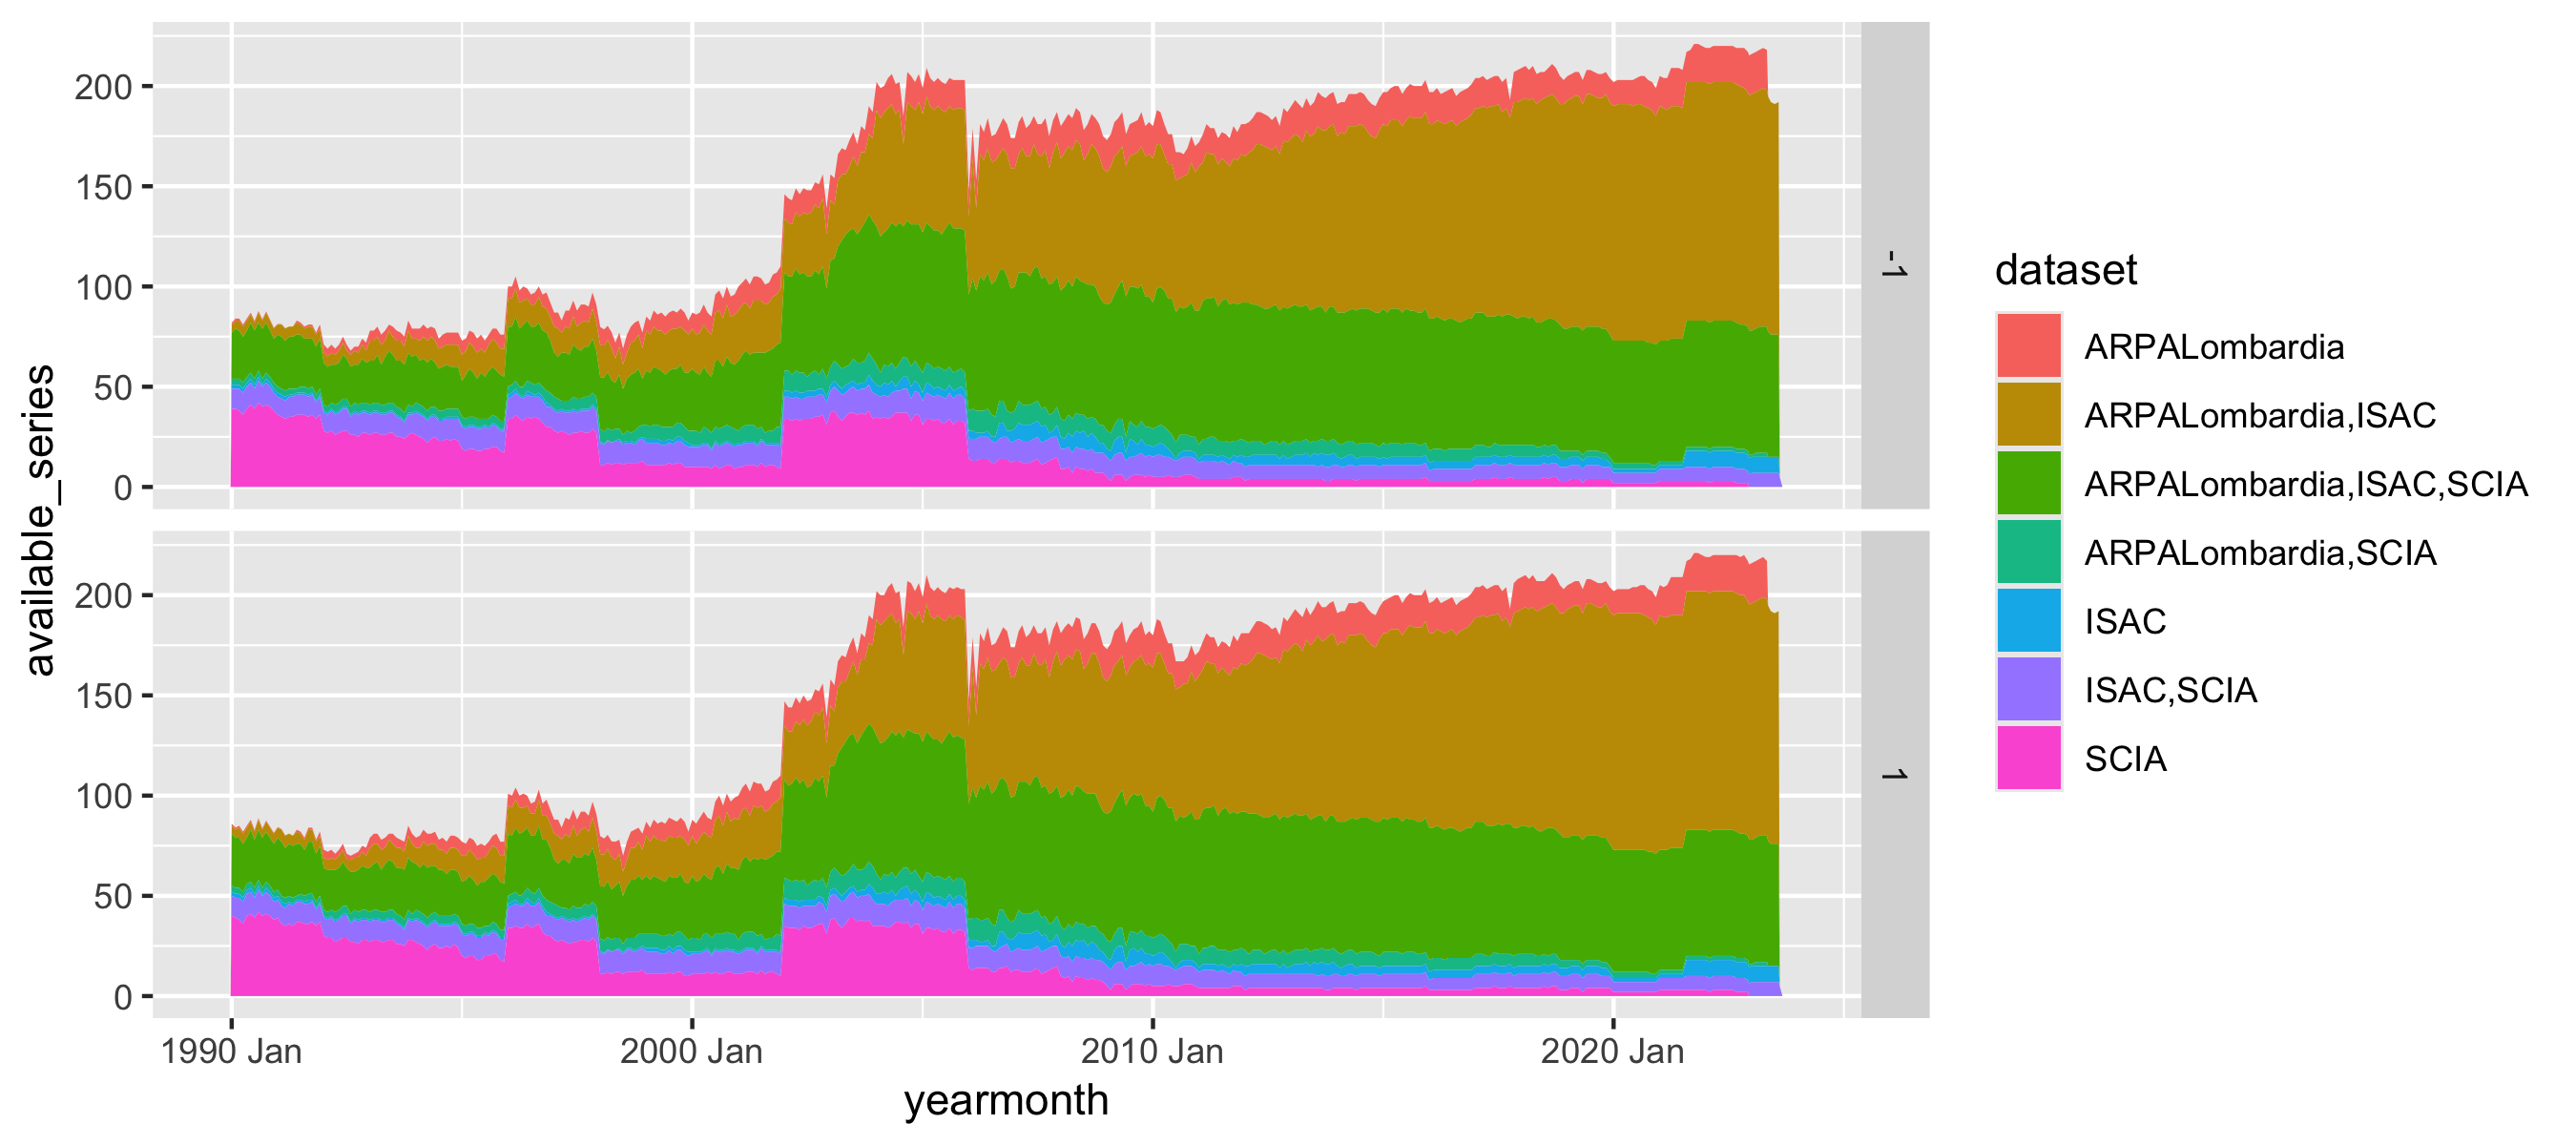

In [16]:
db <- query_checkpoint(new_dataset, "merged", conns$data, all_stations = FALSE)
mt <- db$meta |>
    select(sensor_key, from_datasets) |>
    collect() |>
    rowwise() |>
    mutate(dataset = paste0(from_datasets |> unique() |> sort(), collapse = ",")) |>
    ungroup() |>
    select(-from_datasets)
dt <- db$data |>
    select(-dataset) |>
    left_join(mt, by = "sensor_key", copy = TRUE) |>
    filter(year(date) >= 1990L)
pd <- ymonthly_availabilities(dt, stack = TRUE)
pd$plot + facet_grid(variable ~ .)


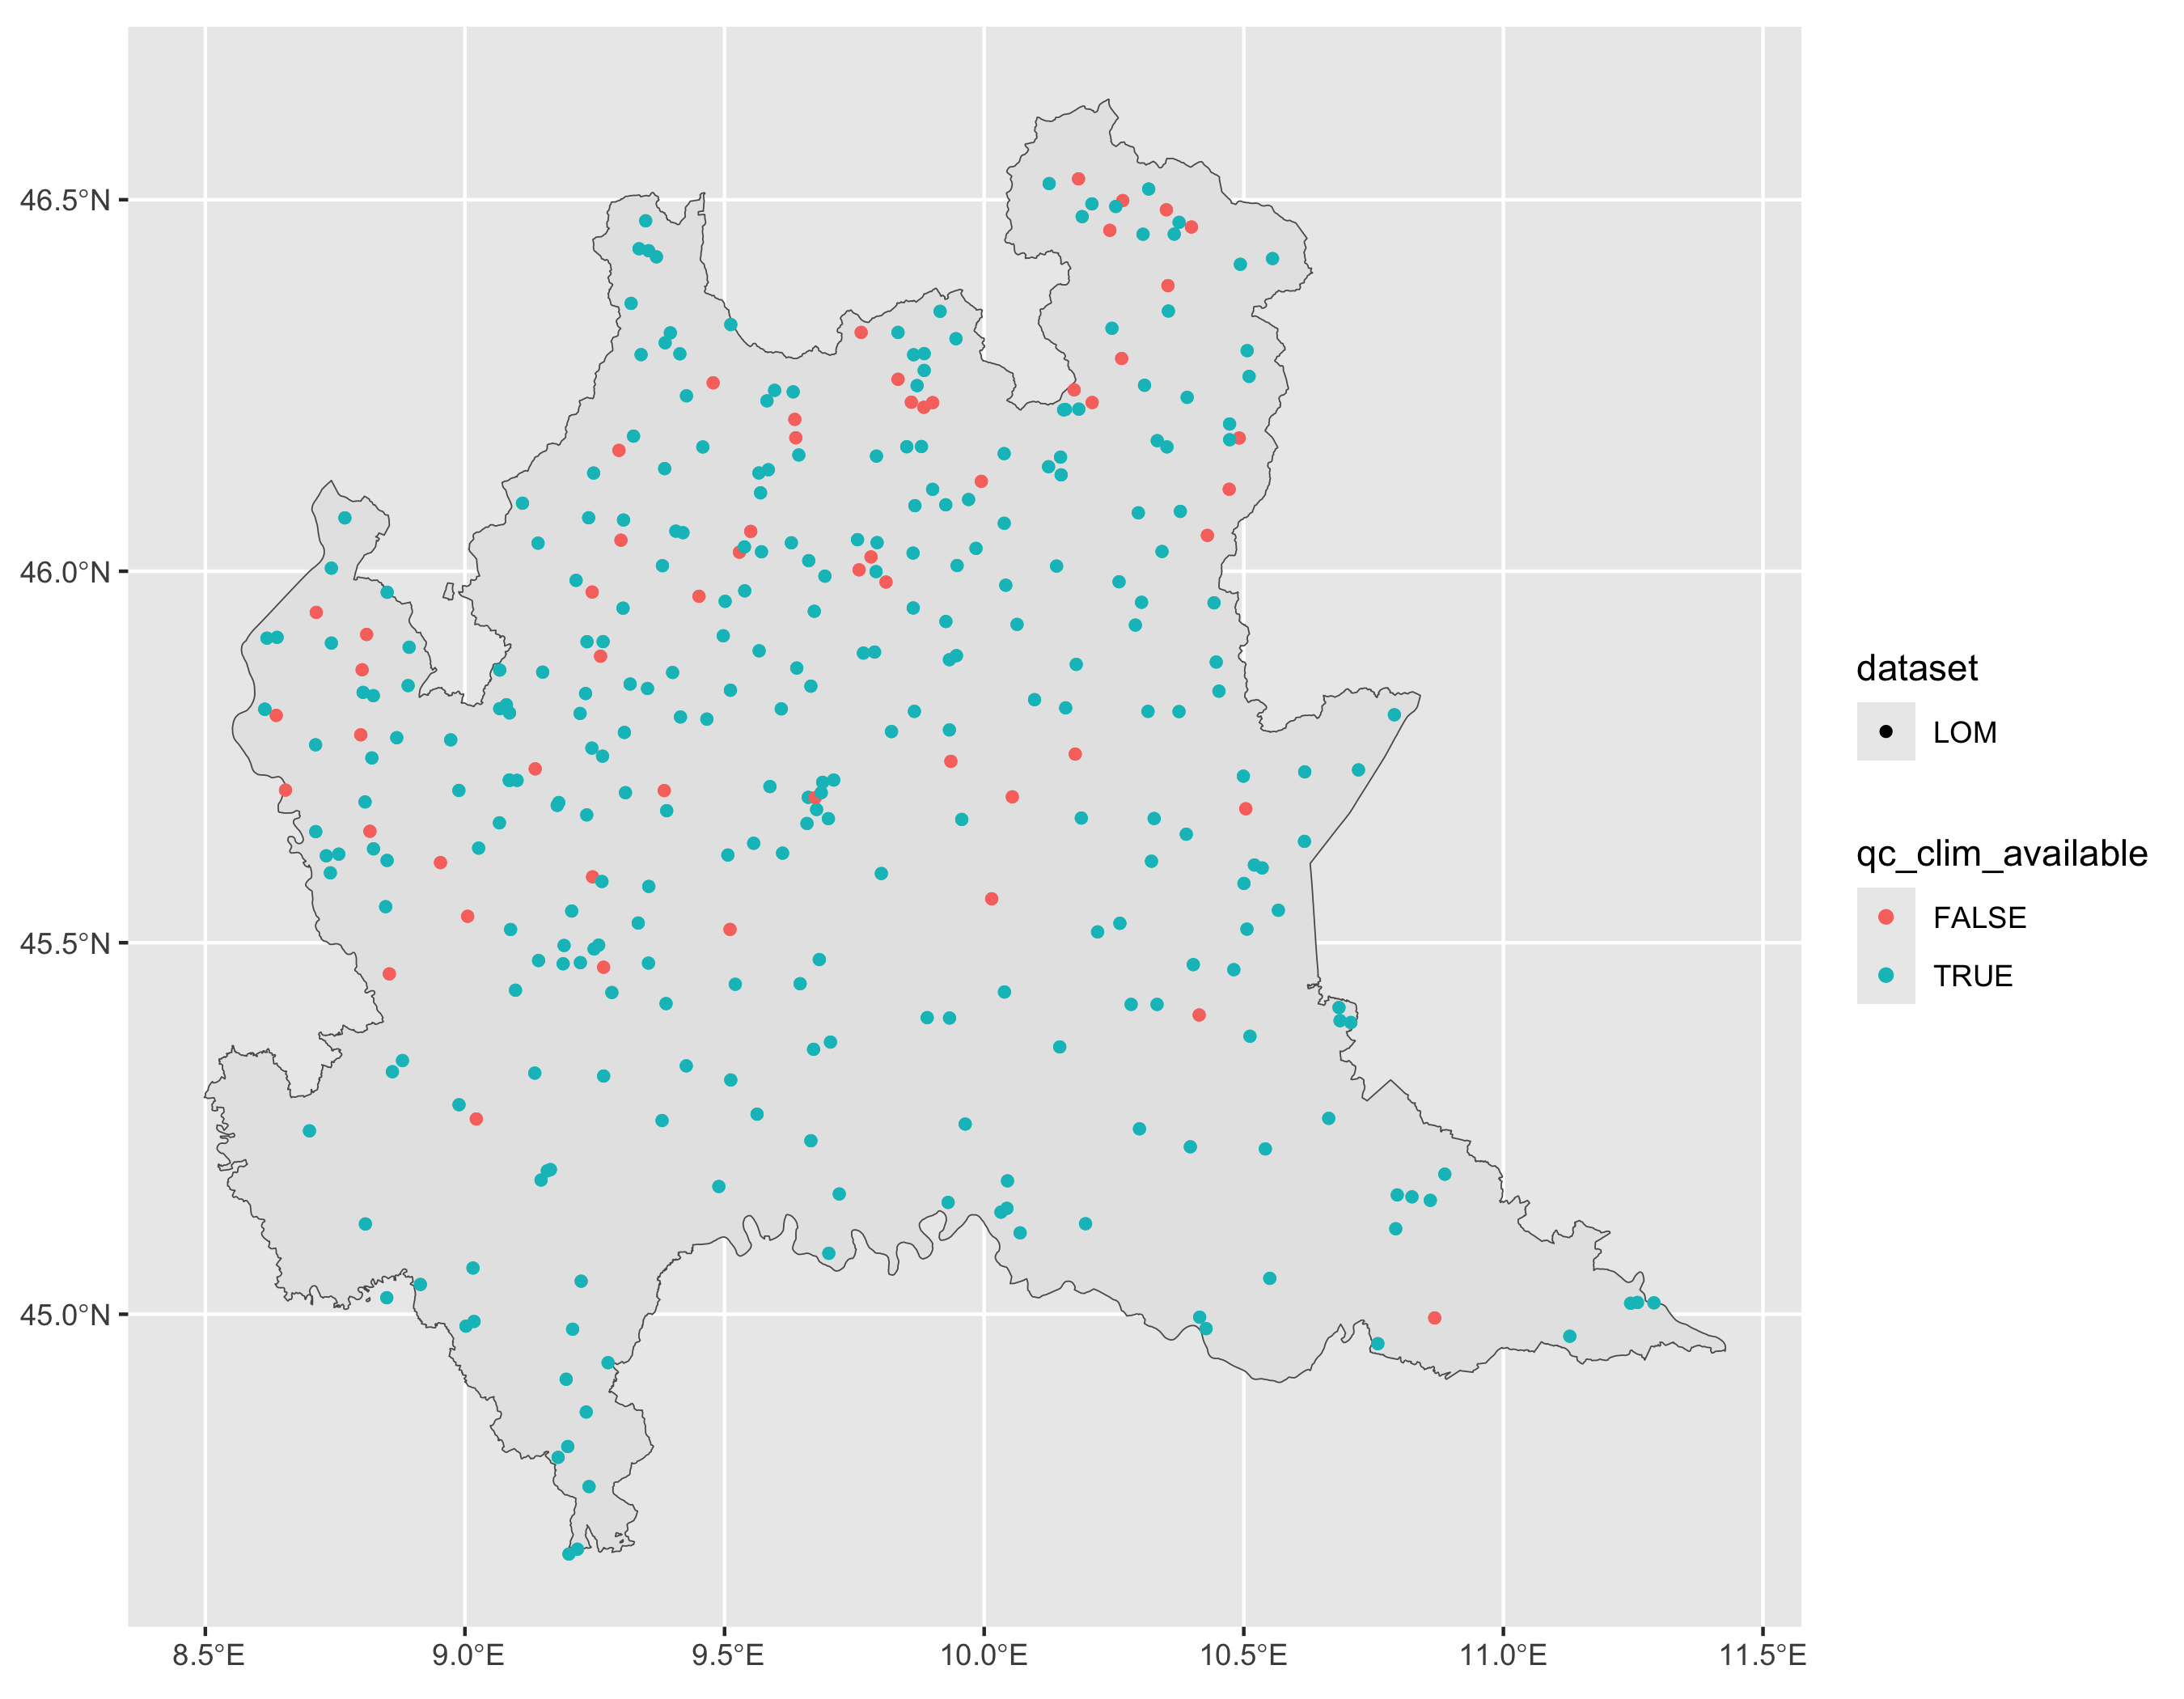

In [33]:
pd <- spatial_availabilities(pd$data |> mutate(dataset = new_dataset), db$meta, state_boundaries, n_years_threshold = 5L)
pd$plot


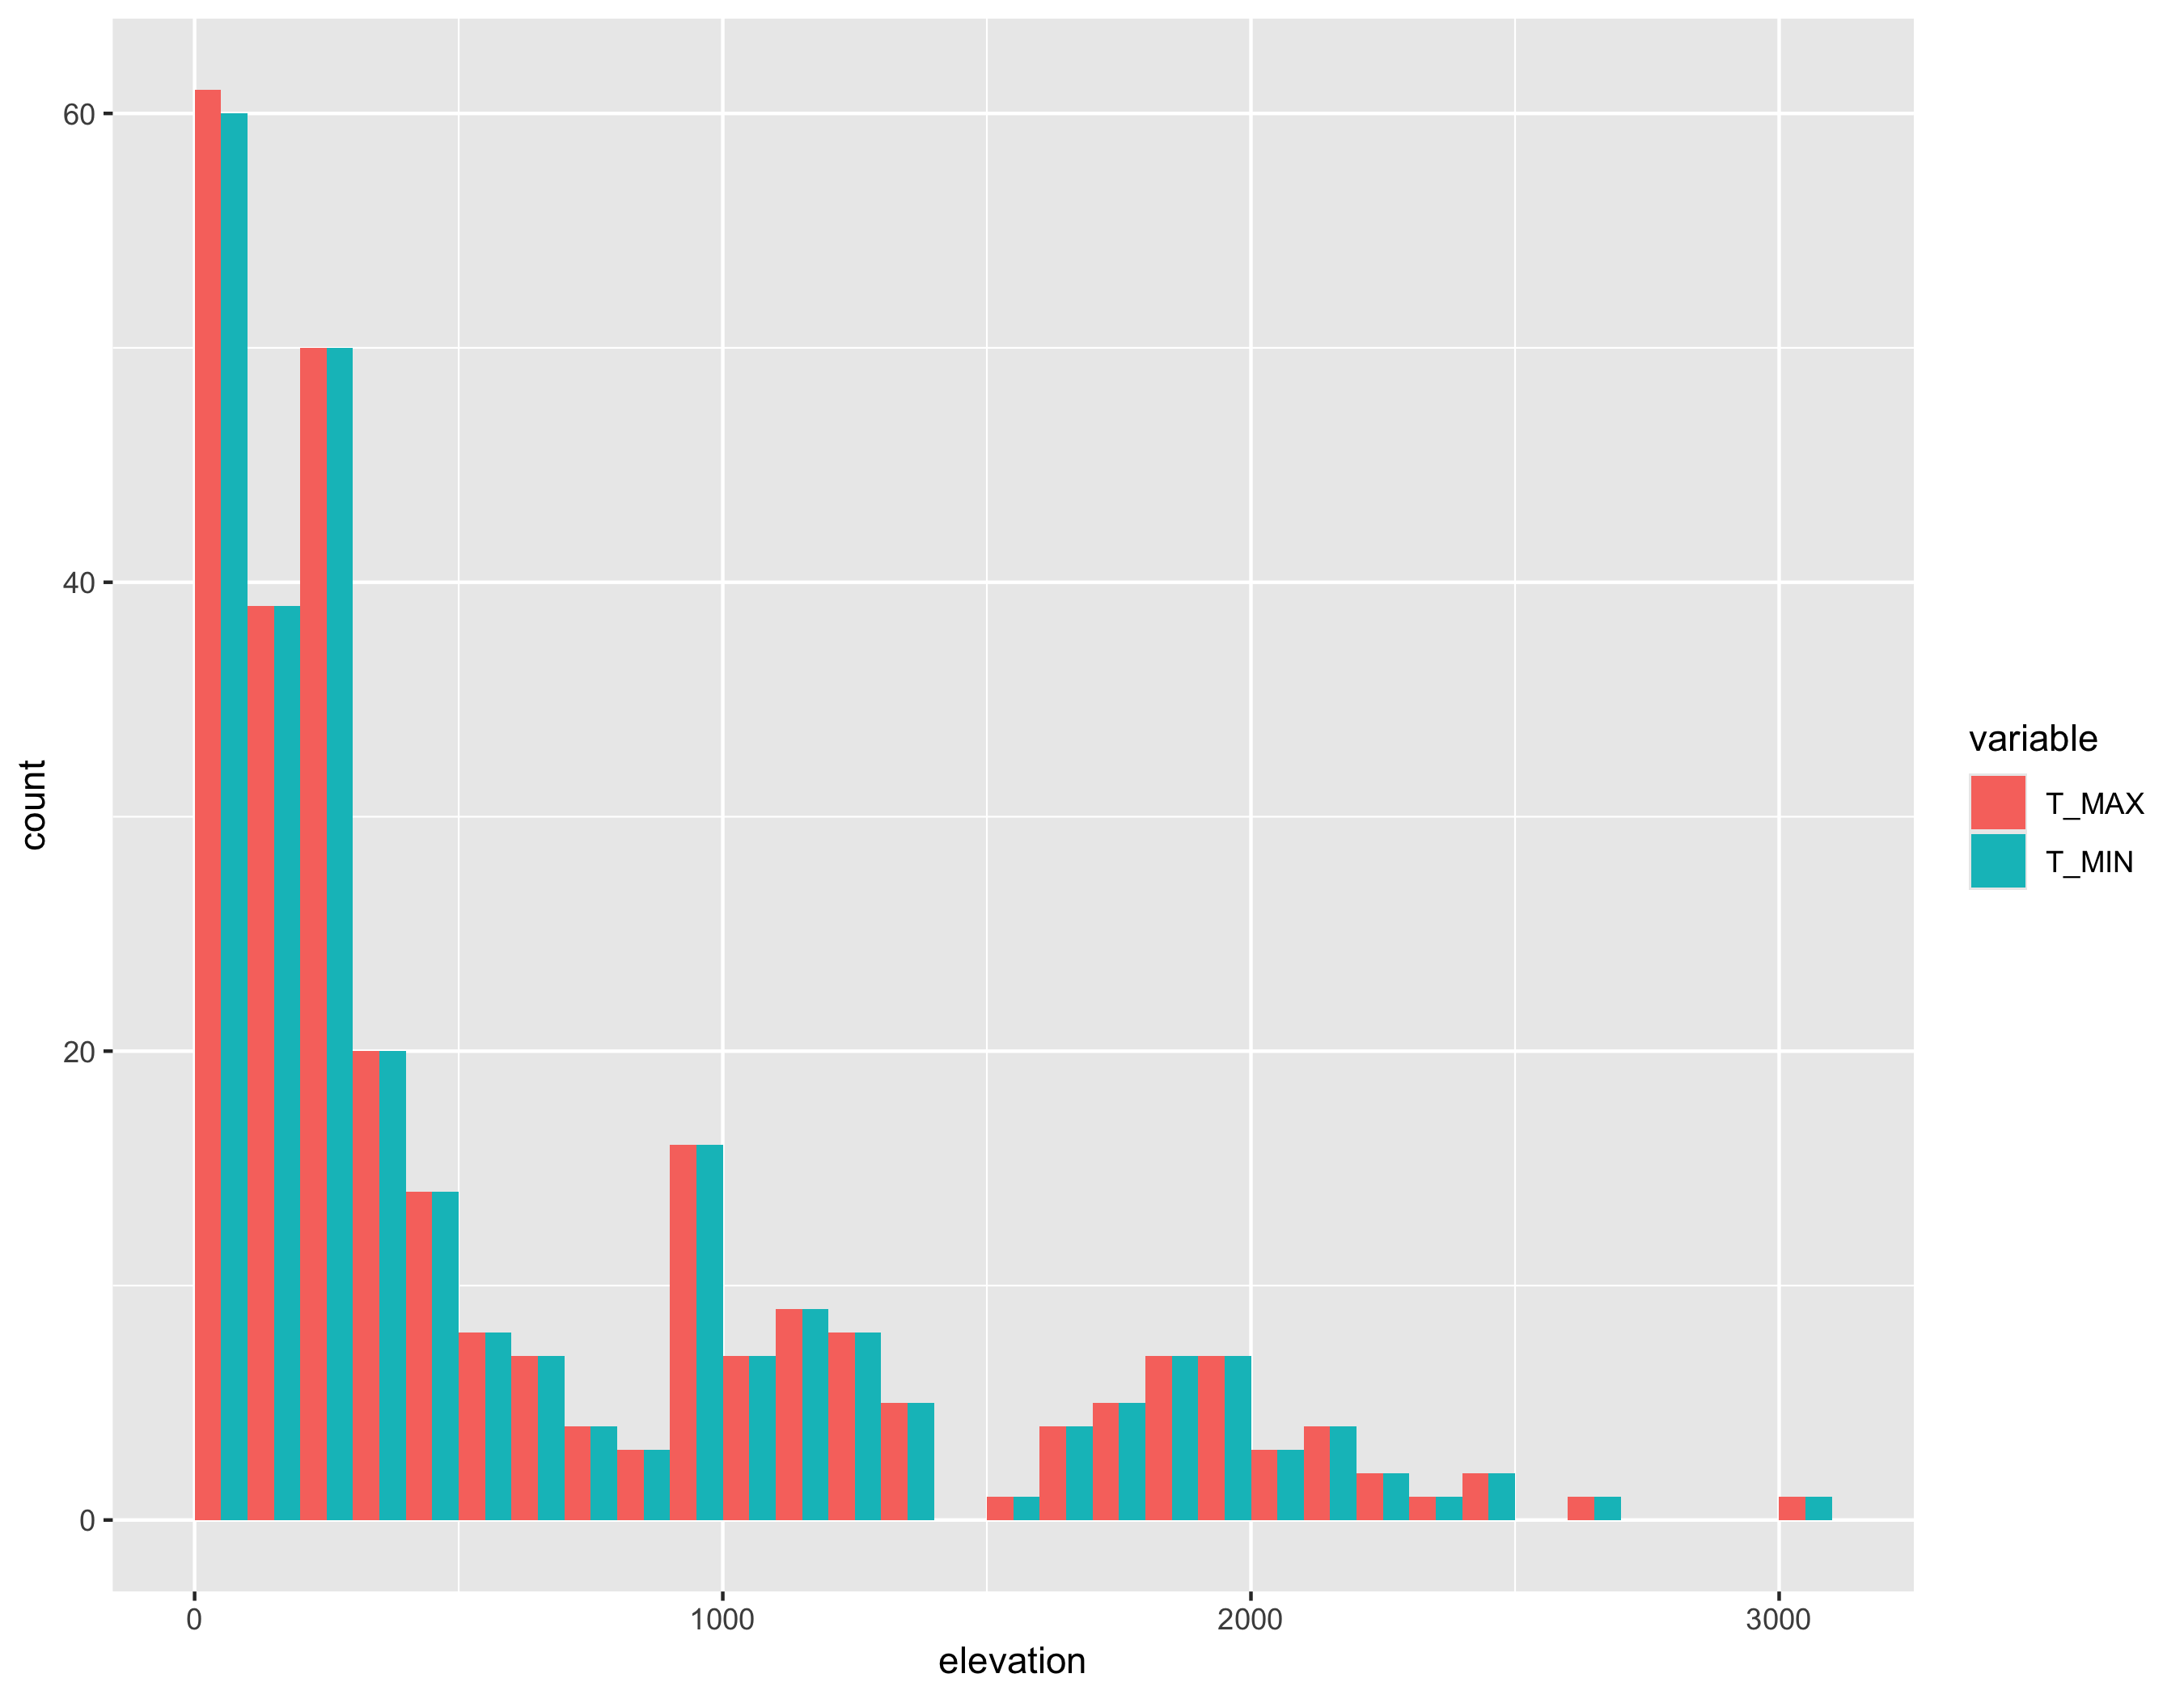

In [34]:
clim_availabilities <- pd$data |> mutate(dataset = new_dataset)
plot_available_by_elevation(clim_availabilities, db$meta |> collect())


In [77]:
source("src/merging/display.R")
show_merge(db$meta, metadata_db, "network", "lon", "lat", "elevation", "sensor_first", "sensor_last") |>
    arrange(master_key) |>
    write.xlsx("lom.xlsx", asTable = TRUE)


In [92]:
mt |>
    filter(dataset == "ISAC") |>
    left_join(db$meta |> collect(), by = "sensor_key")


sensor_key,dataset.x,sensor_id,station_key,station_id,name,network,town,province_full,province_code,...,elevation,elevation_glo30,series_id,dataset.y,from_sensor_keys,from_datasets,series_first,series_last,valid_days,valid90
<int>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,...,<dbl>,<dbl>,<chr>,<chr>,<list>,<list>,<date>,<date>,<int>,<int>
256,ISAC,NA,1778,NA,ALPE_COSTA,DPC,NA,Sondrio,SO,...,1692,1863.77698,LOM_SO_ALPE_COSTA_02_000029400,LOM,87,ISAC,2006-09-05,2009-09-14,974,974
281,ISAC,NA,1610,NA,BRANZI_CASERMA_CARABINIERI,DPC,NA,Bergamo,BG,...,0,832.45441,LOM_BG_BRANZI_CASERMA_CARABINIERI_01_200251102,LOM,432,ISAC,2021-08-01,2023-08-31,761,761
291,ISAC,NA,1760,NA,CABELLA_L_C_COSOLA,DPC,NA,Pavia,PV,...,1526,1577.06384,LOM_PV_CABELLA_L_C_COSOLA_02_000085000,LOM,493,ISAC,2002-01-01,2023-08-31,7107,7107
322,ISAC,NA,1791,NA,CHIESA_IN_VALMALENCO_ALPE_DELL_ORO,DPC,NA,Sondrio,SO,...,0,2033.73828,LOM_SO_CHIESA_IN_VALMALENCO_ALPE_DELL_ORO_01_200251086,LOM,941,ISAC,2021-08-01,2023-08-31,757,757
332,ISAC,NA,1119,NA,COMO_VILLA_GENO,ISAC,NA,Como,CO,...,210,212.41821,IT_LOM_CO_COMO_VILLA_GENO_870_MG,LOM,1062,ISAC,1907-04-15,2019-12-12,26156,8282
345,ISAC,NA,1116,NA,DESENZANO,ISAC,NA,Brescia,BS,...,105,105.01171,IT_LOM_BS_DESENZANO,LOM,1200,ISAC,1951-01-01,1973-05-31,7991,0
357,ISAC,NA,1797,NA,FRODOLFO,DPC,NA,Sondrio,SO,...,1322,1293.57861,LOM_SO_FRODOLFO_02_000098100,LOM,1430,ISAC,2002-11-08,2005-03-30,605,605
370,ISAC,NA,1764,NA,ISOLA_S_ANTONIO,DPC,NA,Pavia,PV,...,75,74.03707,LOM_PV_ISOLA_S_ANTONIO_02_000190600,LOM,1629,ISAC,2002-01-01,2023-08-31,7881,7881
372,ISAC,NA,1802,NA,LAGHI_DI_CHIESA,DPC,NA,Sondrio,SO,...,1318,1346.46033,LOM_SO_LAGHI_DI_CHIESA_02_000031400,LOM,1656,ISAC,2006-09-05,2009-09-14,864,864
